In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import RobertaTokenizer, RobertaModel
import torch

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
df = pd.read_csv('train.csv')  # Replace with your actual file path

# Data Cleaning
df = df.dropna(subset=['text'])  # Remove rows with missing values in the 'text' column
df = df.drop_duplicates()  # Remove duplicates

# Data Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\<.*?\>', '', text)  # Remove HTML tags
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Keep the original cleaned text for later use
X_text = df['cleaned_text'].values  # Save the cleaned text in a separate variable
y = df['target'].values  # Ensure 'target' column is also clean

# Check if there are any NaN values in the target column
if np.any(pd.isna(y)):
    raise ValueError("Target column contains NaN values. Please clean your dataset.")

# Prepare the dataset
X = df['cleaned_text'].values

# Load RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Function to get RoBERTa embeddings
def get_roberta_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()  # Use mean of the last hidden states

# Generate RoBERTa embeddings for the cleaned text
X_embeddings = np.array([get_roberta_embeddings(text) for text in X])

# Step 3: Split the data for training and testing
X_train, X_test, y_train, y_test, X_train_text, X_test_text = train_test_split(X_embeddings, y, X_text, test_size=0.3, random_state=42)

# Step 4: Keyword extraction function
def extract_keywords(text):
    # Split the text into individual words
    return text.split()  # Return the list of words as keywords

# Example of extracting keywords from the training and test sets using the keyword extraction method
X_train_keywords = []  # Initialize an empty list to hold keywords for training instances
X_test_keywords = []  # Initialize an empty list to hold keywords for test instances

# Extract keywords for training set
for text in X_train_text:
    keywords = extract_keywords(text)  # Call the keyword extraction function
    X_train_keywords.append(keywords)

# Extract keywords for test set
for text in X_test_text:
    keywords = extract_keywords(text)  # Call the keyword extraction function
    X_test_keywords.append(keywords)

# -----------------------------------------------------
# Print the extracted keywords for interpretation
# -----------------------------------------------------
print("\nSample extracted keywords from the training set:")
for i in range(min(5, len(X_train_text))):  # Safeguard against fewer than 5 instances
    print(f"\nSentence {i + 1}:")
    print(f"Original Text: {X_train_text[i]}")  # Print the original cleaned text from the training set
    print(f"Extracted Keywords: {X_train_keywords[i]}")  # Print extracted keywords

print("\nSample extracted keywords from the test set:")
for i in range(min(5, len(X_test_text))):  # Safeguard against fewer than 5 instances
    print(f"\nSentence {i + 1}:")
    print(f"Original Text: {X_test_text[i]}")  # Print the original cleaned text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Print extracted keywords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Sample extracted keywords from the training set:

Sentence 1:
Original Text: ash australia collapse trent bridge among worst history england bundled australia
Extracted Keywords: ['ash', 'australia', 'collapse', 'trent', 'bridge', 'among', 'worst', 'history', 'england', 'bundled', 'australia']

Sentence 2:
Original Text: great michigan technique camp bg thanks bmurph hailyoutsey termnr goblue wrestleon
Extracted Keywords: ['great', 'michigan', 'technique', 'camp', 'bg', 'thanks', 'bmurph', 'hailyoutsey', 'termnr', 'goblue', 'wrestleon']

Sentence 3:
Original Text: cnn tennessee movie theater shooting suspect killed police
Extracted Keywords: ['cnn', 'tennessee', 'movie', 'theater', 'shooting', 'suspect', 'killed', 'police']

Sentence 4:
Original Text: still rioting couple hour left class
Extracted Keywords: ['still', 'rioting', 'couple', 'hour', 'left', 'class']

Sentence 5:
Original Text: crack path wiped morning beach run surface wound left elbow right knee
Extracted Keywords: ['cra

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Shape of RoBERTa embeddings:", X_embeddings.shape)

Shape of RoBERTa embeddings: (7613, 768)


In [ ]:
print("Total samples:", len(X_embeddings))
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))
print("Training labels:", len(y_train))
print("Testing labels:", len(y_test))
print("Training text:", len(X_train_text))
print("Testing text:", len(X_test_text))


Total samples: 7613
Training samples: 5329
Testing samples: 2284
Training labels: 5329
Testing labels: 2284
Training text: 5329
Testing text: 2284


In [ ]:
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resample with SMOTE

# Define the parameter grid for Decision Tree with additional tuning options
param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 50],  # Increasing depth for more complexity
    'min_samples_split': [2, 5, 10, 20],  # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],  # Minimum number of samples to be at a leaf node
    'criterion': ['gini', 'entropy'],  # Try both 'gini' and 'entropy'
    'class_weight': ['balanced', None],  # Try balancing class weights
    'max_leaf_nodes': [None, 10, 20, 50],  # Limit the number of leaves to prevent overfitting
    'min_impurity_decrease': [0.0, 0.01, 0.1],  # Set the minimum impurity decrease for pruning
}

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_dt = RandomizedSearchCV(
    dt_model, param_distributions=param_grid_dt,
    n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search_dt.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found for Decision Tree: ", random_search_dt.best_params_)

# Get the best model from RandomizedSearchCV
best_dt_model = random_search_dt.best_estimator_

# Predict and evaluate on the test set
y_test_pred_dt = best_dt_model.predict(X_test)  # Replace X_test with your test set embeddings
print("Decision Tree Performance on Test Set:\n", classification_report(y_test, y_test_pred_dt))

# Calculate and print test accuracy
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)
print(f"Test Accuracy with Decision Tree: {test_accuracy_dt:.4f}")

# Save the trained Decision Tree model to a file using joblib
model_filename_dt = 'decision_tree_model_with_smote.pkl'
joblib.dump(best_dt_model, model_filename_dt)
print(f"Trained Decision Tree model saved to {model_filename_dt}")

# -----------------------------------------------------
# Print the extracted keywords for interpretation
# -----------------------------------------------------
print("\nSample extracted keywords from the test set (for the first 5 instances):")
for i in range(5):  # Print the first 5 test samples and their extracted keywords
    print(f"\nSentence {i+1}:")
    print(f"Original Text: {X_test_text[i]}")  # Original text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Extracted keywords


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for Decision Tree:  {'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 20, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': None}
Decision Tree Performance on Test Set:
               precision    recall  f1-score   support

           0       0.74      0.86      0.80      1318
           1       0.76      0.59      0.66       966

    accuracy                           0.75      2284
   macro avg       0.75      0.73      0.73      2284
weighted avg       0.75      0.75      0.74      2284

Test Accuracy with Decision Tree: 0.7469
Trained Decision Tree model saved to decision_tree_model_with_smote.pkl

Sample extracted keywords from the test set (for the first 5 instances):

Sentence 1:
Original Text: new weapon cause unimaginable destruction
Extracted Keywords: ['new', 'weapon', 'cause', 'unimaginable', 'destruction']

Sentence 2:
Original Text: fam

In [ ]:
import joblib
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resample with SMOTE

# Define the parameter grid for MLPClassifier with additional tuning options
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (100, 50), (150, 100)],  # Vary hidden layer sizes
    'activation': ['relu', 'tanh'],  # Activation functions to try
    'solver': ['adam', 'sgd'],  # Solvers for optimization
    'alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization term)
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
    'learning_rate_init': [0.001, 0.01],  # Initial learning rate
    'max_iter': [200, 300, 500],  # Number of iterations to run
    'batch_size': [64, 128, 256],  # Batch size for training
}

# Initialize the MLPClassifier model
mlp_model = MLPClassifier(random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_mlp = RandomizedSearchCV(
    mlp_model, param_distributions=param_grid_mlp,
    n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search_mlp.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found for MLP: ", random_search_mlp.best_params_)

# Get the best model from RandomizedSearchCV
best_mlp_model = random_search_mlp.best_estimator_

# Predict and evaluate on the test set
y_test_pred_mlp = best_mlp_model.predict(X_test)  # Replace X_test with your test set embeddings
print("MLP Performance on Test Set:\n", classification_report(y_test, y_test_pred_mlp))

# Calculate and print test accuracy
test_accuracy_mlp = accuracy_score(y_test, y_test_pred_mlp)
print(f"Test Accuracy with MLP: {test_accuracy_mlp:.4f}")

# Save the trained MLP model to a file using joblib
model_filename_mlp = 'mlp_model_with_smote.pkl'
joblib.dump(best_mlp_model, model_filename_mlp)
print(f"Trained MLP model saved to {model_filename_mlp}")

# -----------------------------------------------------
# Print the extracted keywords for interpretation
# -----------------------------------------------------
print("\nSample extracted keywords from the test set (for the first 5 instances):")
for i in range(5):  # Print the first 5 test samples and their extracted keywords
    print(f"\nSentence {i+1}:")
    print(f"Original Text: {X_test_text[i]}")  # Original text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Extracted keywords


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for MLP:  {'solver': 'adam', 'max_iter': 200, 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'batch_size': 64, 'alpha': 0.001, 'activation': 'tanh'}
MLP Performance on Test Set:
               precision    recall  f1-score   support

           0       0.80      0.77      0.79      1318
           1       0.71      0.74      0.72       966

    accuracy                           0.76      2284
   macro avg       0.75      0.76      0.75      2284
weighted avg       0.76      0.76      0.76      2284

Test Accuracy with MLP: 0.7592
Trained MLP model saved to mlp_model_with_smote.pkl

Sample extracted keywords from the test set (for the first 5 instances):

Sentence 1:
Original Text: new weapon cause unimaginable destruction
Extracted Keywords: ['new', 'weapon', 'cause', 'unimaginable', 'destruction']

Sentence 2:
Original Text: famping thing gishwhes got soaked delu

In [ ]:
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resample with SMOTE

# Define the parameter grid for SVM with additional tuning options
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernel types
    'degree': [2, 3, 4],  # Degree of the polynomial kernel (only relevant for 'poly' kernel)
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'class_weight': ['balanced', None],  # Handling class imbalance
    'tol': [1e-3, 1e-4, 1e-5],  # Tolerance for stopping criterion
}

# Initialize the SVM model
svm_model = SVC(random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_svm = RandomizedSearchCV(
    svm_model, param_distributions=param_grid_svm,
    n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search_svm.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found for SVM: ", random_search_svm.best_params_)

# Get the best model from RandomizedSearchCV
best_svm_model = random_search_svm.best_estimator_

# Predict and evaluate on the test set
y_test_pred_svm = best_svm_model.predict(X_test)  # Replace X_test with your test set embeddings
print("SVM Performance on Test Set:\n", classification_report(y_test, y_test_pred_svm))

# Calculate and print test accuracy
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
print(f"Test Accuracy with SVM: {test_accuracy_svm:.4f}")

# Save the trained SVM model to a file using joblib
model_filename_svm = 'svm_model_with_smote.pkl'
joblib.dump(best_svm_model, model_filename_svm)
print(f"Trained SVM model saved to {model_filename_svm}")

# -----------------------------------------------------
# Optional: Print the extracted keywords for interpretation (if applicable)
# -----------------------------------------------------
print("\nSample extracted keywords from the test set (for the first 5 instances):")
for i in range(5):  # Print the first 5 test samples and their extracted keywords
    print(f"\nSentence {i+1}:")
    print(f"Original Text: {X_test_text[i]}")  # Original text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Extracted keywords


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for SVM:  {'tol': 0.0001, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'class_weight': None, 'C': 10}
SVM Performance on Test Set:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      1318
           1       0.77      0.76      0.77       966

    accuracy                           0.80      2284
   macro avg       0.80      0.80      0.80      2284
weighted avg       0.80      0.80      0.80      2284

Test Accuracy with SVM: 0.8039
Trained SVM model saved to svm_model_with_smote.pkl

Sample extracted keywords from the test set (for the first 5 instances):

Sentence 1:
Original Text: new weapon cause unimaginable destruction
Extracted Keywords: ['new', 'weapon', 'cause', 'unimaginable', 'destruction']

Sentence 2:
Original Text: famping thing gishwhes got soaked deluge going pad tampon thx mishacollins
Extracted Keywords: ['famping', 'thing', 'gishwh

In [ ]:
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resample with SMOTE

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500],  # Number of trees
    'max_depth': [3, 5, 10],  # Maximum depth of a tree
    'learning_rate': [0.001, 0.01, 0.1],  # Step size shrinkage to prevent overfitting
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for fitting individual trees
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used for tree construction
    'gamma': [0, 0.1, 0.3],  # Minimum loss reduction for further partitioning
    'reg_lambda': [1, 1.5, 2.0],  # L2 regularization term on weights
    'scale_pos_weight': [1, 3, 5]  # Control class imbalance (higher for imbalance)
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_xgb = RandomizedSearchCV(
    xgb_model, param_distributions=param_grid_xgb,
    n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search_xgb.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found for XGBoost: ", random_search_xgb.best_params_)

# Get the best model from RandomizedSearchCV
best_xgb_model = random_search_xgb.best_estimator_

# Predict and evaluate on the test set
y_test_pred_xgb = best_xgb_model.predict(X_test)  # Replace X_test with your test set embeddings
print("XGBoost Performance on Test Set:\n", classification_report(y_test, y_test_pred_xgb))

# Calculate and print test accuracy
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
print(f"Test Accuracy with XGBoost: {test_accuracy_xgb:.4f}")

# Save the trained XGBoost model to a file using joblib
model_filename_xgb = 'xgboost_model_with_smote.pkl'
joblib.dump(best_xgb_model, model_filename_xgb)
print(f"Trained XGBoost model saved to {model_filename_xgb}")

# -----------------------------------------------------
# Optional: Print the extracted keywords for interpretation (if applicable)
# -----------------------------------------------------
print("\nSample extracted keywords from the test set (for the first 5 instances):")
for i in range(5):  # Print the first 5 test samples and their extracted keywords
    print(f"\nSentence {i+1}:")
    print(f"Original Text: {X_test_text[i]}")  # Original text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Extracted keywords


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:25:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found for XGBoost:  {'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 1.5, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}
XGBoost Performance on Test Set:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84      1318
           1       0.79      0.74      0.77       966

    accuracy                           0.81      2284
   macro avg       0.80      0.80      0.80      2284
weighted avg       0.81      0.81      0.81      2284

Test Accuracy with XGBoost: 0.8069
Trained XGBoost model saved to xgboost_model_with_smote.pkl

Sample extracted keywords from the test set (for the first 5 instances):

Sentence 1:
Original Text: new weapon cause unimaginable destruction
Extracted Keywords: ['new', 'weapon', 'cause', 'unimaginable', 'destruction']

Sentence 2:
Original Text: famping thing gishwhes got soaked deluge going pad tampon thx mishacollins
Extracted Keywords: ['fa

In [ ]:
import joblib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resample with SMOTE

# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 500],  # Number of boosting stages
    'max_depth': [3, 5, 10],  # Maximum depth of the individual regression estimators
    'learning_rate': [0.001, 0.01, 0.1],  # Learning rate shrinks contribution of each tree
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for fitting the individual base learners
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5],  # Minimum number of samples required to be a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    'min_impurity_decrease': [0.0, 0.01, 0.1],  # Minimum impurity decrease for a node split
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_gb = RandomizedSearchCV(
    gb_model, param_distributions=param_grid_gb,
    n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search_gb.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found for Gradient Boosting: ", random_search_gb.best_params_)

# Get the best model from RandomizedSearchCV
best_gb_model = random_search_gb.best_estimator_

# Predict and evaluate on the test set
y_test_pred_gb = best_gb_model.predict(X_test)  # Replace X_test with your test set embeddings
print("Gradient Boosting Performance on Test Set:\n", classification_report(y_test, y_test_pred_gb))

# Calculate and print test accuracy
test_accuracy_gb = accuracy_score(y_test, y_test_pred_gb)
print(f"Test Accuracy with Gradient Boosting: {test_accuracy_gb:.4f}")

# Save the trained Gradient Boosting model to a file using joblib
model_filename_gb = 'gradient_boosting_model_with_smote.pkl'
joblib.dump(best_gb_model, model_filename_gb)
print(f"Trained Gradient Boosting model saved to {model_filename_gb}")

# -----------------------------------------------------
# Optional: Print the extracted keywords for interpretation (if applicable)
# -----------------------------------------------------
print("\nSample extracted keywords from the test set (for the first 5 instances):")
for i in range(5):  # Print the first 5 test samples and their extracted keywords
    print(f"\nSentence {i+1}:")
    print(f"Original Text: {X_test_text[i]}")  # Original text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Extracted keywords


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for Gradient Boosting:  {'subsample': 1.0, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.1}
Gradient Boosting Performance on Test Set:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      1318
           1       0.78      0.74      0.76       966

    accuracy                           0.81      2284
   macro avg       0.80      0.80      0.80      2284
weighted avg       0.80      0.81      0.80      2284

Test Accuracy with Gradient Boosting: 0.8052
Trained Gradient Boosting model saved to gradient_boosting_model_with_smote.pkl

Sample extracted keywords from the test set (for the first 5 instances):

Sentence 1:
Original Text: new weapon cause unimaginable destruction
Extracted Keywords: ['new', 'weapon', 'cause', 'unimaginable', 'destructio

In [ ]:
import joblib
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resample with SMOTE

# Define the parameter grid for LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200, 500],  # Number of boosting rounds
    'num_leaves': [31, 50, 100],  # Maximum number of leaves in one tree
    'max_depth': [-1, 10, 20, 30],  # Maximum depth of trees
    'learning_rate': [0.001, 0.01, 0.1],  # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used per iteration
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used per iteration
    'min_child_weight': [1, 5, 10],  # Minimum sum of instance weight needed in a child node
    'reg_alpha': [0, 0.1, 1.0],  # L1 regularization term
    'reg_lambda': [0, 0.1, 1.0],  # L2 regularization term
    'scale_pos_weight': [1, 3, 5],  # Weight for balancing positive and negative classes
}

# Initialize the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_lgb = RandomizedSearchCV(
    lgb_model, param_distributions=param_grid_lgb,
    n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search_lgb.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found for LightGBM: ", random_search_lgb.best_params_)

# Get the best model from RandomizedSearchCV
best_lgb_model = random_search_lgb.best_estimator_

# Predict and evaluate on the test set
y_test_pred_lgb = best_lgb_model.predict(X_test)  # Replace X_test with your test set embeddings
print("LightGBM Performance on Test Set:\n", classification_report(y_test, y_test_pred_lgb))

# Calculate and print test accuracy
test_accuracy_lgb = accuracy_score(y_test, y_test_pred_lgb)
print(f"Test Accuracy with LightGBM: {test_accuracy_lgb:.4f}")

# Save the trained LightGBM model to a file using joblib
model_filename_lgb = 'lightgbm_model_with_smote.pkl'
joblib.dump(best_lgb_model, model_filename_lgb)
print(f"Trained LightGBM model saved to {model_filename_lgb}")

# -----------------------------------------------------
# Optional: Print the extracted keywords for interpretation (if applicable)
# -----------------------------------------------------
print("\nSample extracted keywords from the test set (for the first 5 instances):")
for i in range(5):  # Print the first 5 test samples and their extracted keywords
    print(f"\nSentence {i+1}:")
    print(f"Original Text: {X_test_text[i]}")  # Original text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Extracted keywords


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 3024, number of negative: 3024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 6048, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters found for LightGBM:  {'subsample': 0.8, 'scale_pos_weight': 3, 'reg_lambda': 0.1, 'reg_alpha': 1.0, 'num_leaves': 50, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
LightGBM Performance on Test Set:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81      1318
           1       0.73      0.78      0.75       966

    accuracy                           0.78      2284
   ma

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.2 MB/s eta 0:00:00


  0%|          | 0/2284 [00:00<?, ?it/s]

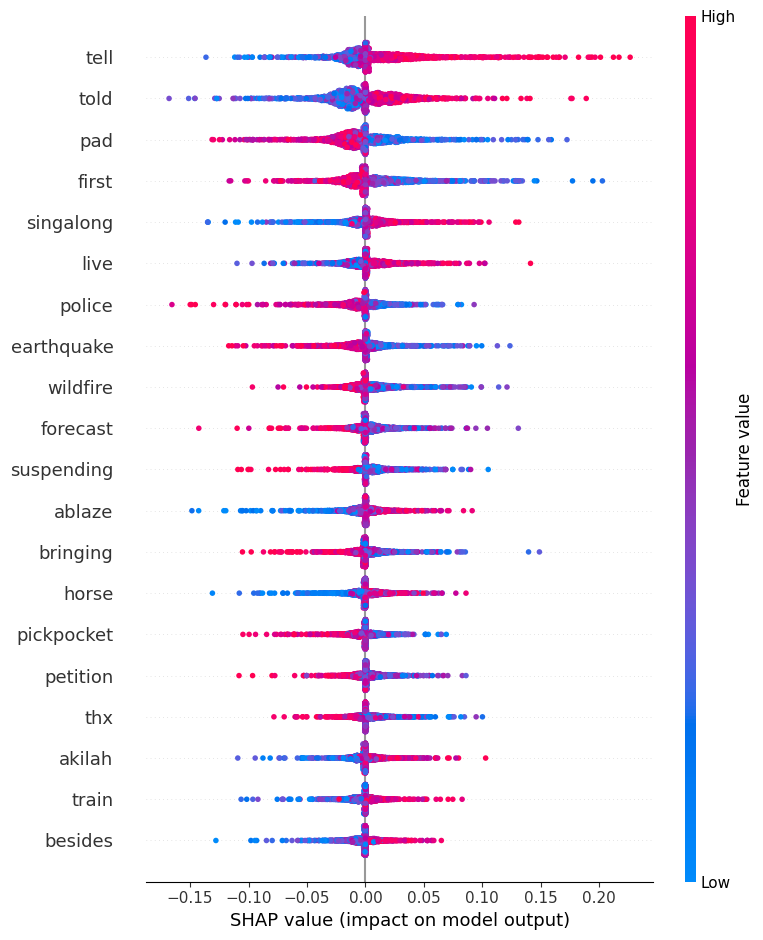

Streaming output truncated to the last 5000 lines.
  6.14560656e-02  4.63627502e-02  2.60848291e-02  9.44765136e-02
  2.30834454e-01 -1.79526098e-02  5.89575246e-02 -2.77471971e-02
 -5.89153962e-03  3.18425260e-02 -1.91678926e-01  9.35658514e-02
  1.04095051e-02  1.24805957e-01  8.57669488e-02 -1.51152954e-01
  8.06189403e-02 -4.17107251e-03  4.98779602e-02  2.19350345e-02
  1.11963540e-01  9.31731910e-02 -1.06168866e-01  6.15136437e-02
  1.35003731e-01  1.20440729e-01  5.48095964e-02  5.58371283e-02
  4.68004569e-02  2.34751180e-02  3.60817388e-02 -1.30537286e-01
  4.49946485e-02  5.56021854e-02  5.73974587e-02 -2.06053779e-02
  4.26661894e-02  3.23115326e-02 -6.27018232e-03 -9.90020111e-02
  6.75303265e-02  1.20450176e-01  5.60796596e-02 -3.85089256e-02
 -6.25349581e-02  1.62327033e-03  8.16655681e-02  6.95513636e-02
 -3.08474936e-02 -1.77278034e-02  4.62891310e-02 -2.76650744e-03
  7.87113532e-02  9.63015705e-02 -3.46656889e-02 -4.95854840e-02
 -1.17485873e-01  5.59023805e-02  5.870

In [13]:
import numpy as np
import shap

# Ensure X_test is a NumPy array if it's not already
if isinstance(X_test, tuple):
    X_test = np.array(X_test)

# Sample the background data to reduce computation time (using nsamples, not K)
background_data = shap.sample(X_train_resampled, nsamples=20)  # Sample 20 background samples

# Initialize the SHAP explainer with the best model (Replace 'best_model' with your actual best model)
# Use 'best_mlp_model', 'best_svm_model', 'best_xgb_model', 'best_gb_model', 'best_lgb_model' as needed
explainer = shap.KernelExplainer(best_xgb_model.predict, background_data)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(np.array(X_test))

# Create a mapping for feature names using the keywords extracted
feature_names = []
for keywords in X_test_keywords:
    feature_names.extend(keywords)  # Extend feature names with the list of keywords directly

# Generate a SHAP summary plot with meaningful feature names
shap.summary_plot(shap_values, features=np.array(X_test), feature_names=feature_names)

# Print the extracted keywords for interpretation (for the first 100 instances)
print("\nSample extracted keywords from the test set (for the first 100 instances):")
for i in range(100):  # Print the first 100 test samples and their extracted keywords
    print(f"\nSentence {i + 1}:")
    print(f"Original Text: {X_test[i]}")  # Replace X_test with original text for RoBERTa inputs
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # No need to call .keys() since it's already a list


In [1]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9fda7ee65550506d9674f37752ae2ccf9a07c907a07cc89c6a4a4e7697016a67
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
